# Pre-processing and clustering 3k PBMCs with scanpy

Author: Jitao David Zhang
Date: 13.05.2020

<a rel="licence" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="figures/CC-BY-SA-4.0.png" /></a><br />The document is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International Licence</a>.

We document the pre-processing and clustering of 3000 PBMCs from a helathy data with the help of the scanpy package. The content is largely copied from https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html, though I have added my own comments to help new learners grasp a few technicalities that I struggled with.

In [1]:
## Data download. If you run the script for the first time, uncomment the three lines below by removing #
## Because the Jupyter notebook recognizes lines that start with ! as command-line commands
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz; rm !$

**Note** In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB`` after you enter the function. Hit it twice to expand the view.

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

/home/david/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [3]:
## verbosity setting: 0 for errors, 1 for warnings, 2 for info, and 3 for hitns
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.0 statsmodels==0.11.1 python-igraph==0.8.2


In [4]:
results_file = './write/pbmc3k.h5ad' ## the file that will store the analysis results

In [5]:
## read in annotated data
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19', # the directory with the '.mtx' file
    var_names='gene_symbols',                # use gene symbols as the variable names
    cache=True)                              # write a cache file for fastter subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata.var_names_make_unique() # not necessary if `var_names='gene_ids'` is used in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

## Preprocessing

### Checking highly expressed genes

First we show genes that yield the highest fraction of counts in each single cell, across all cells.

The `sc.pl.highest_expr_genes` command normalizses counts per cell, and plots the genes that are most abundant in each cell. Note that MALAT1, a non-coding RNA that is known to be extremely abundant in many cells, ranks at the top.

normalizing counts per cell
    finished (0:00:00)


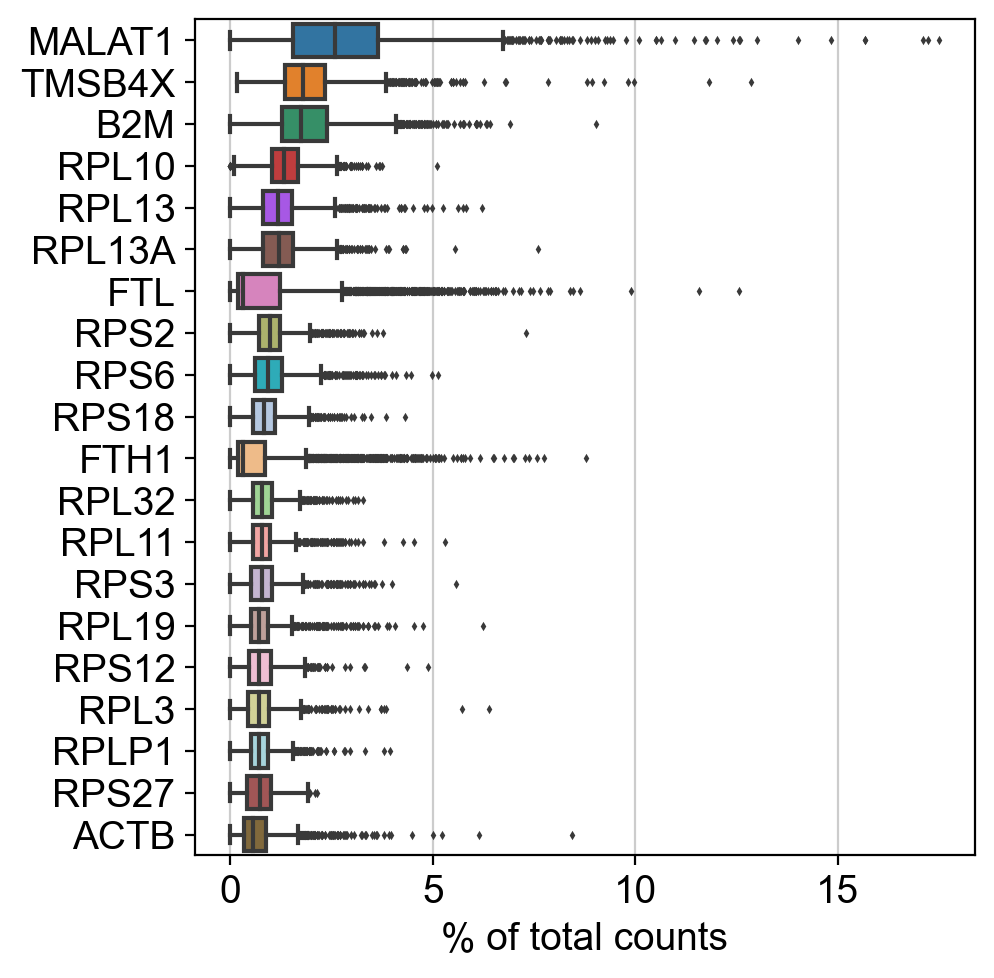

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Filtering the cells

The two commands below remove cells that have fewer than 200 genes detected, and genes that are detected in fewer than 3 cells.

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


### Checking mitochondrial genes for QC

High proportions of mitochondrial genes indicate poor-quality cells, maybe because of loss of cytoplasmic RNA from perforated cells.

In [10]:
## the command line uses the fact that mitochondrial genes have gene symbols prefixed with 'MT-'
mito_genes = adata.var_names.str.startswith('MT-')
## for each cell, we compute the fraction of counts in mitochondrial genes versus all genes
## The `.A1` is only necessary since X is sparse. It transforms to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
## add the total counts per cell as observations-annotation to adata
adata.obs["n_counts"] = adata.X.sum(axis=1).A1

We can use a *violin plot* to visulize computed quality measures. The 'n_genes' property was already there, and we have just added 'percent_mito' and 'n_counts' to the observation annotation. The ``sc.pl.violin`` function accepts adata and keys to make Violin plots.

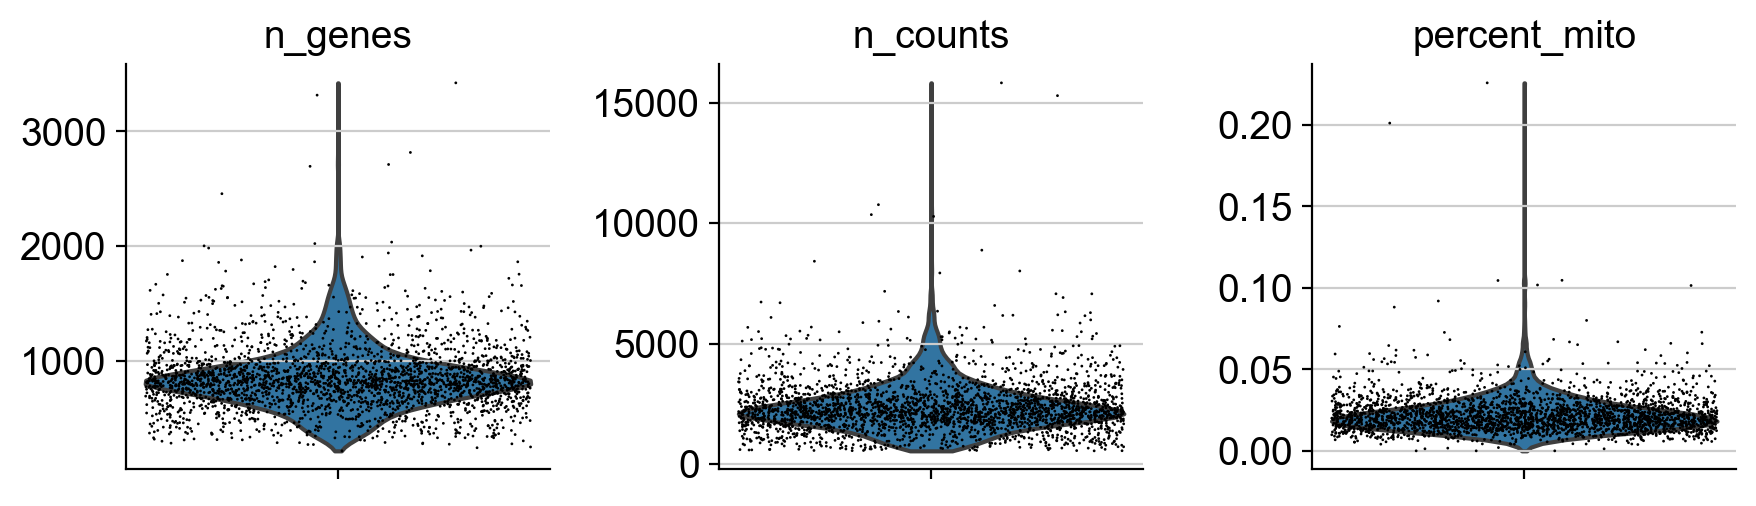

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
            jitter=0.4, multi_panel=True)

We also wish to remove cells that either have too many reads mapped to mitochondrial genes, which may indicate poor-quality cells, or have too many total counts, which may indicate cell aggregates. The following two plots help us identify the thresholds.

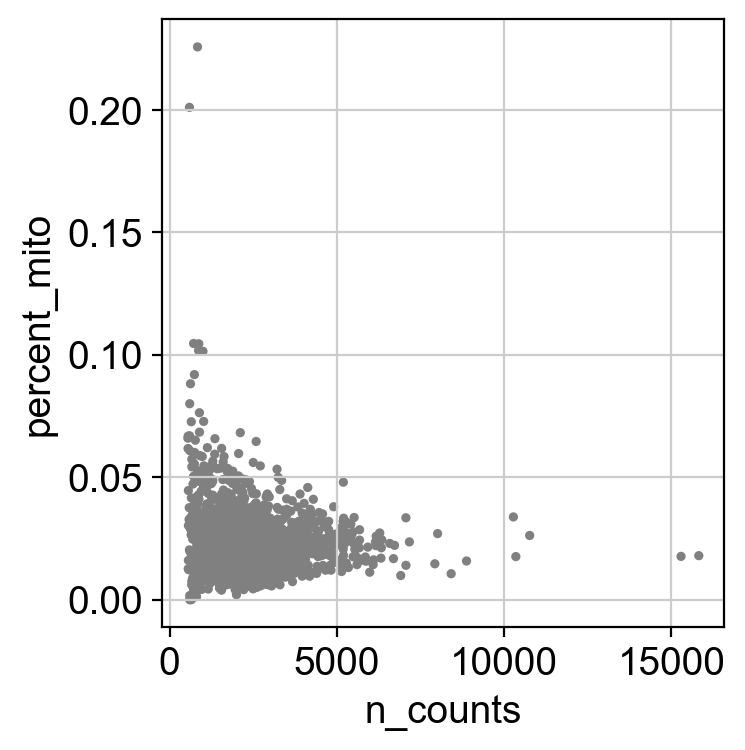

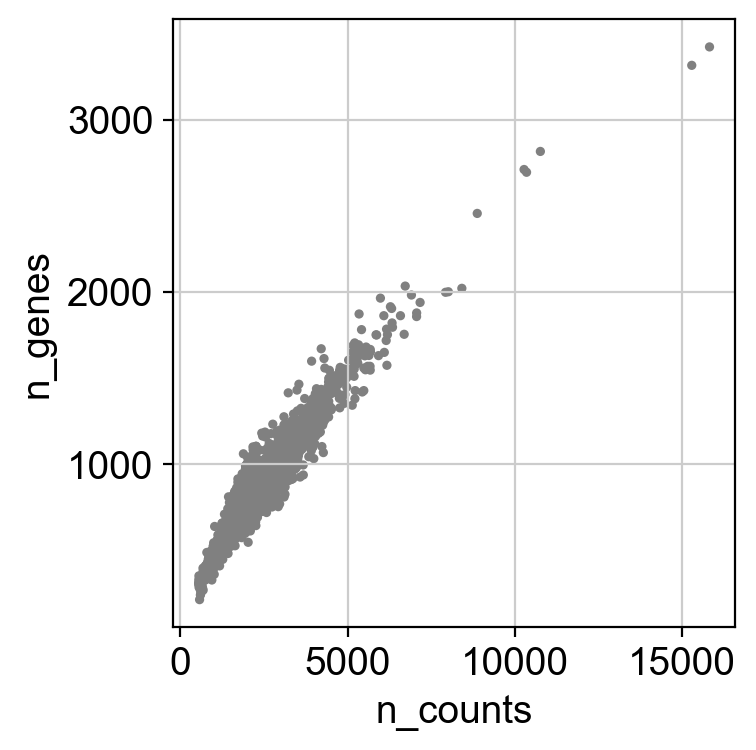

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

### Filtering with metrics derived from QC

Now we are ready to do the actual filtering. Before the filtering, the dataset looks like this. There are 2,700 cells and 13,714 genes.

In [13]:
print(adata)

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [14]:
adata = adata[adata.obs.n_genes<2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [15]:
print(adata)

View of AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


### Data normlization

To correct differences in library sizes across cells, we normalize the total read count of the data matrix to 10,000 reads per cell so that counts become comparable among cells.

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:03)


We logarithmize the data for later use in differential gene expression as well as in visualizations. The natural logarithm is used, and ``log1p`` means that an extra read is added to cells of the count matrix as a pseudo-read.

In [17]:
sc.pp.log1p(adata)

/home/david/.local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


### Saving the data in the .raw attribute

This allows a later reuse of the raw data

In [18]:
adata.raw = adata

### Identifying highly-variable genes

The function `sc.pp.highly_variable_genes` can detect highly variable genes based on a few manually set parameters, including mininum mean expression, maximum mean expression, and minimum dispersion. Since in many cases, we care about rather the genes that differentiate different cells, we can focus our analysis on such highly variable genes.

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


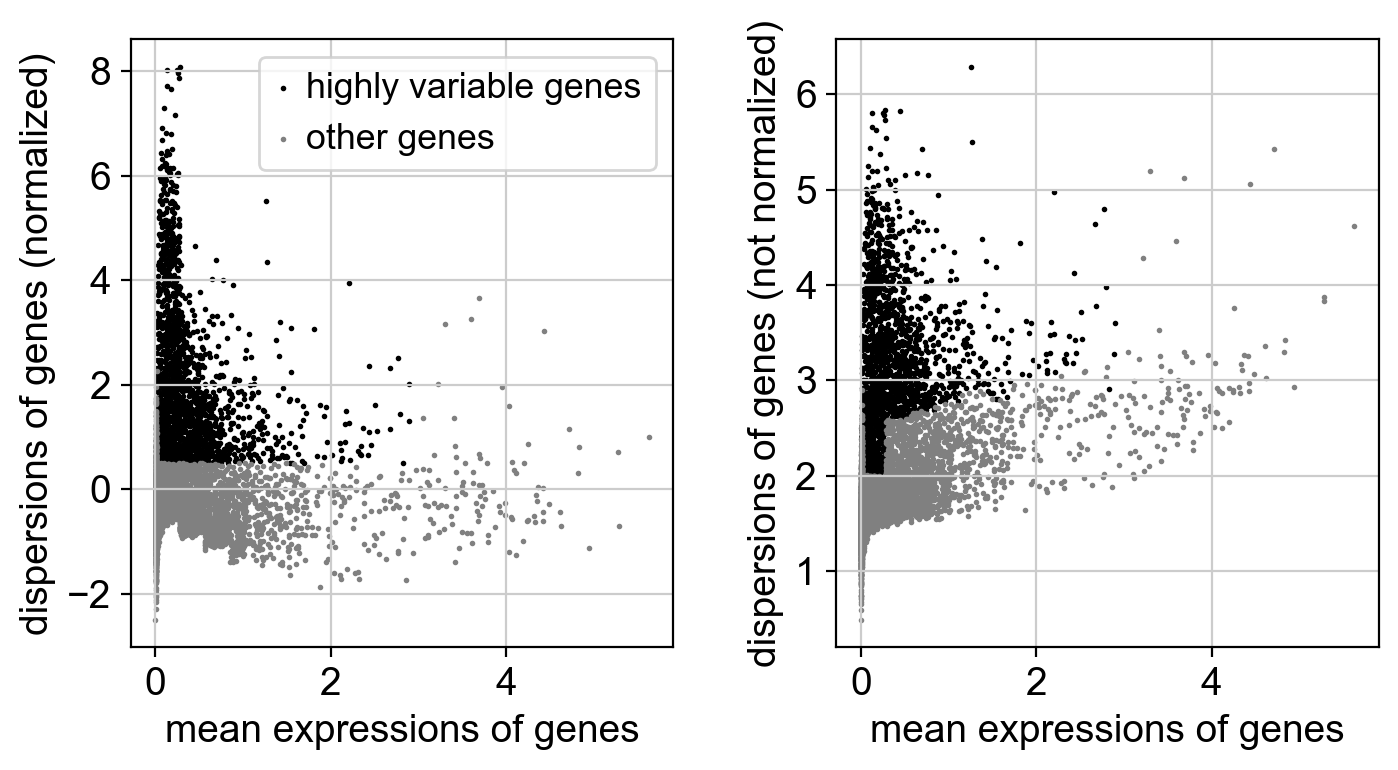

In [20]:
sc.pl.highly_variable_genes(adata)

We filter the `adata` object so that only genes that are highly variable are kept.

In [21]:
adata = adata[:, adata.var.highly_variable]

### Remove effects of counts per cell and mitochondria gene expression

We can use the technique of linear regression to remove (correct for) the effects of counts per cell and mitochondria gene expression. This can consume quite some memory and take some time because the input data is sparse.

In [22]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:19)


### Center the data to zero and scale the data to unit variance

We center the average expression per gene to zero, which is done by `sc.pp.scale` using the default parameter (zero_center:bool=True), and scale each gene to the unit variance. We also clip scaled values that exceed 10.

In [23]:
sc.pp.scale(adata, max_value=10)

## Dimension reduction with PCA

We first use principal component analysis (PCA), a linear dimention-reduction technique, to visualize the main axes of variation and to denoise the data.

In [24]:
sc.tl.pca(adata, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)


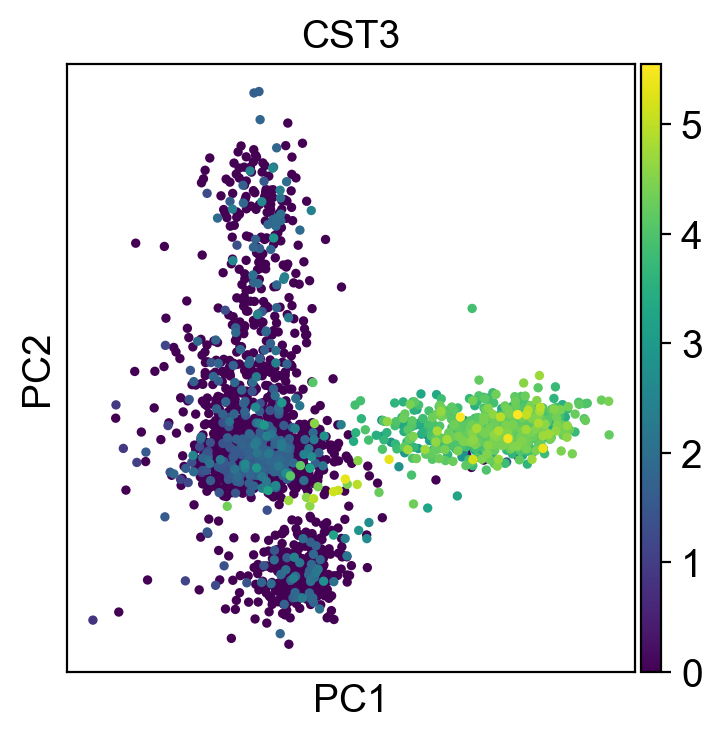

In [25]:
sc.pl.pca(adata, color="CST3")

The variance ratio plot lists contributions of individual principal components (PC) to the total variance in the data. This piece of information helps us to choose an appropriate number of PCs in order to compute the neighborhood relationships between the cells, for instance, using the clustering method Louvain `sc.tl.louvain()` or the embedding method tSNE `sc.tl.tsne()` for dimension-reduction.

According to the authors of `scanpy`, a rough estimate of the number of PCs does fine.

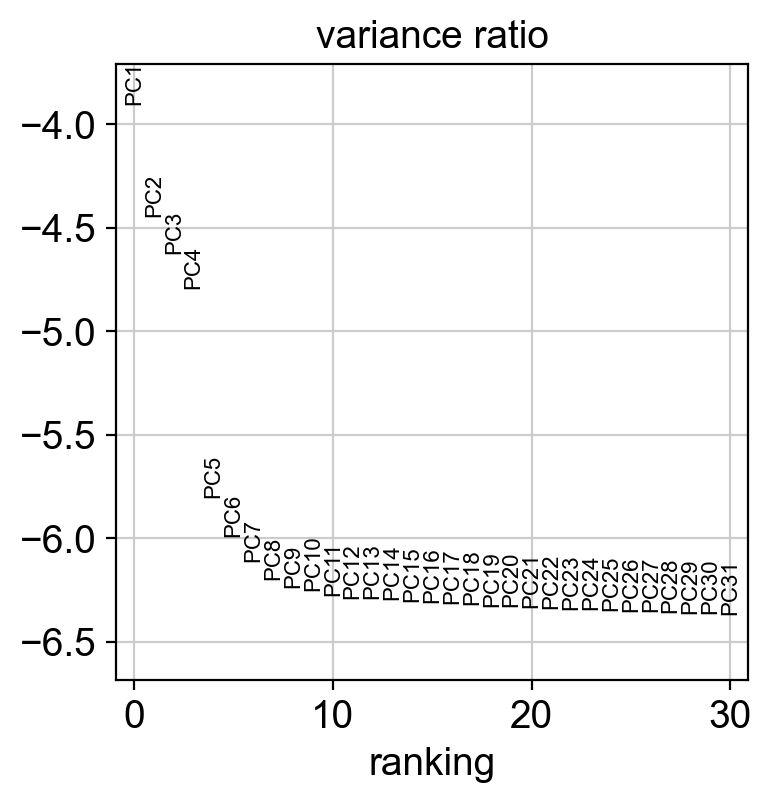

In [26]:
sc.pl.pca_variance_ratio(adata, log=True)

We svae the result up to PCA analysis.

In [27]:
! mkdir -p write
adata.write(results_file)

Note that our `adata` object has following elements: observations annotation (`obs`), variables (`var`), unstructured annotation (`uns`), multi-dimensional observations annotation (`obsm`), and multi-dimensional variables annotation (`varm`). The meanings of these parameters are documented in the `anndata` package, available at [anndata documentation](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html).

In [28]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighbourbood graph


We use the PCA representation of the data matrix to computer the neighborhood graph of cells. By default, the method relies on the UMAP algorithm to find neighbourhoods of cells.

UMAP is a non-linear dimension reduction algorithm. In essence, it seeks to learn the manifold structure of the data, and tries to find a low dimensional embedding that preserves the essential topological structure of that manifold.

What is a manifold? In mathematics, a manifold is a topological space that locally resembles Euclidean space near each point. For instance, a playground is flat for practical reasons such as football playing or measuring its perimeter. However, in fact the playground is part of the earth, which is not flat at all. Since the properties of a small-enough area of the surface of a ideal ball are almost like a flat surface, we can say that the ball is a manifold. 

Why it matters? Because from the point of view of algebraic topology topological data analysis, the UMAP algorithm uses Riehamannian geometry to bring real-world data closer to the underlying assumptions of the tological data analysis algorithm. There I confess I still have a lot of things that I do not understand and need to learn.

The final product is a low-dimensional presentation of the manifold in which the neightborhood relationship between points in the manifold is kept as much as possible. And such a representation in 2D can help us grasp which cells are most similar to each other while are different from others. 

An introduction to how UMAP works can be found in the documentation of [UMAP-learn](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

In [29]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/home/david/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)


## Embedding the neighbourhood graph

The authors of scanpy advertise mebdding the graph in two dimensions using UMAP. It is potentially more faithful to the global connectivity of the manifold than tSNE, for instance for trajectory analysis.



In [30]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


Let us visualize a few genes using the UMAP layout, using raw gene expression that are normalized, logarithmized, but not corrected.

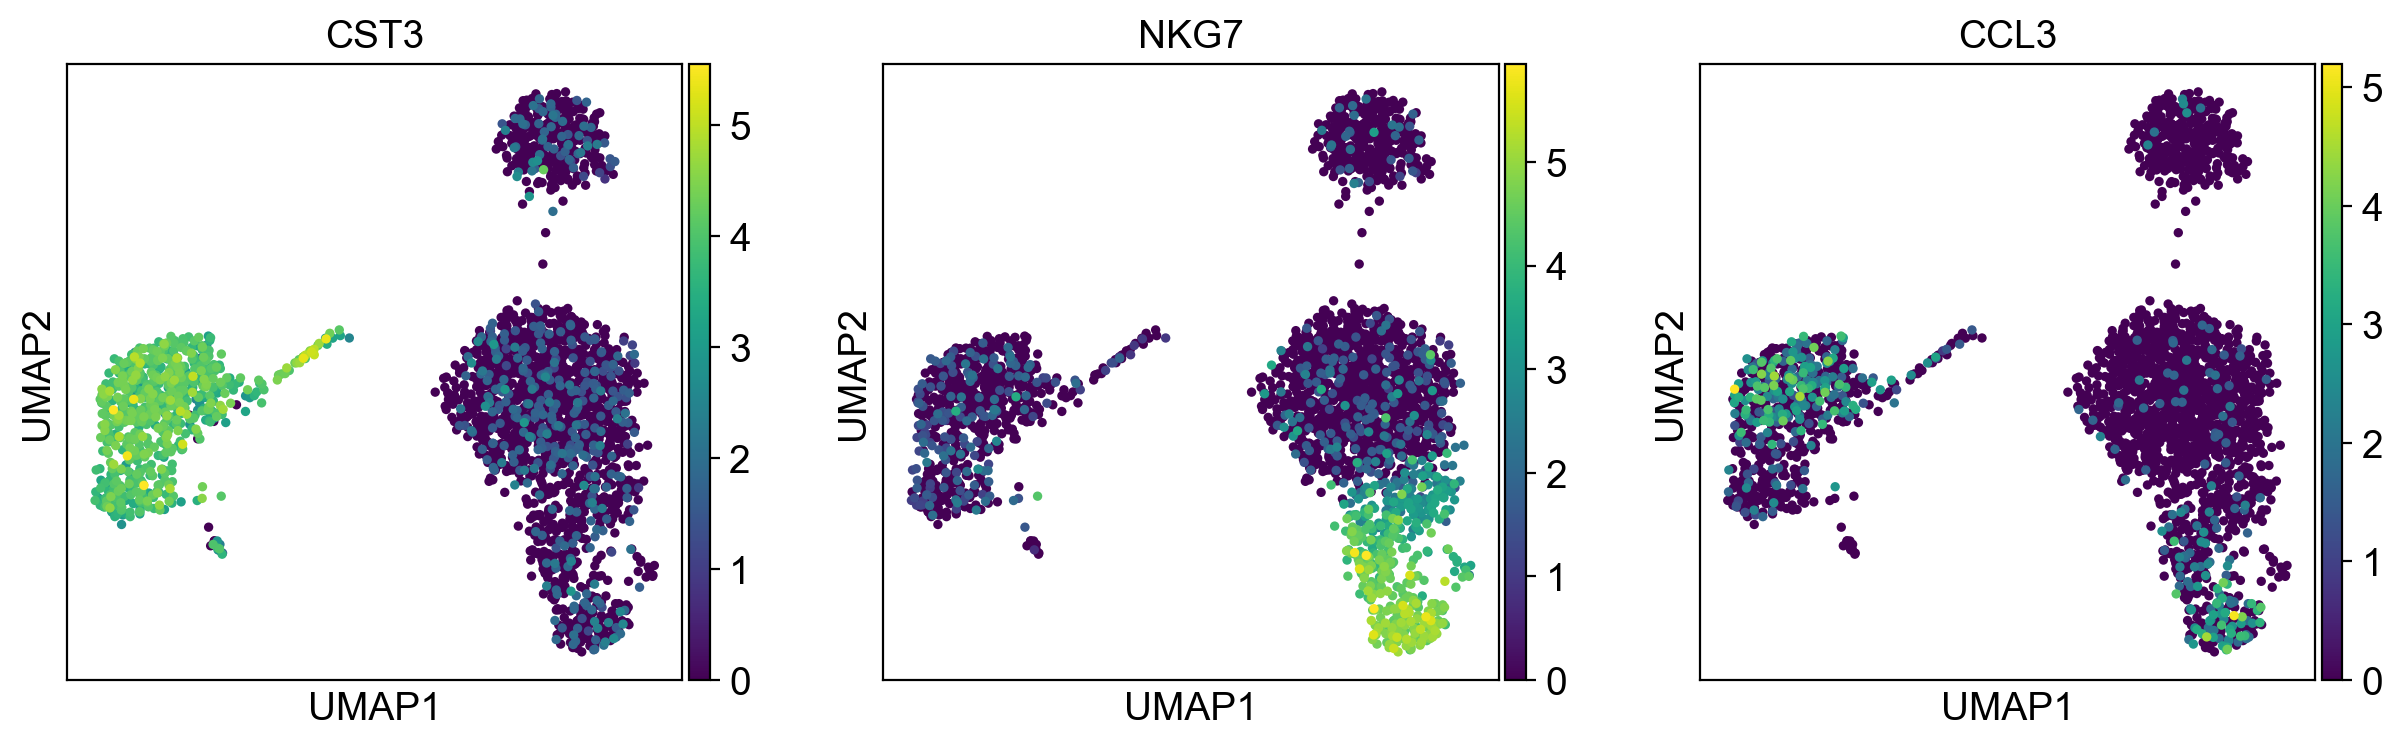

In [31]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'CCL3'])

Now we draw the same plots, but using corrected gene expression data

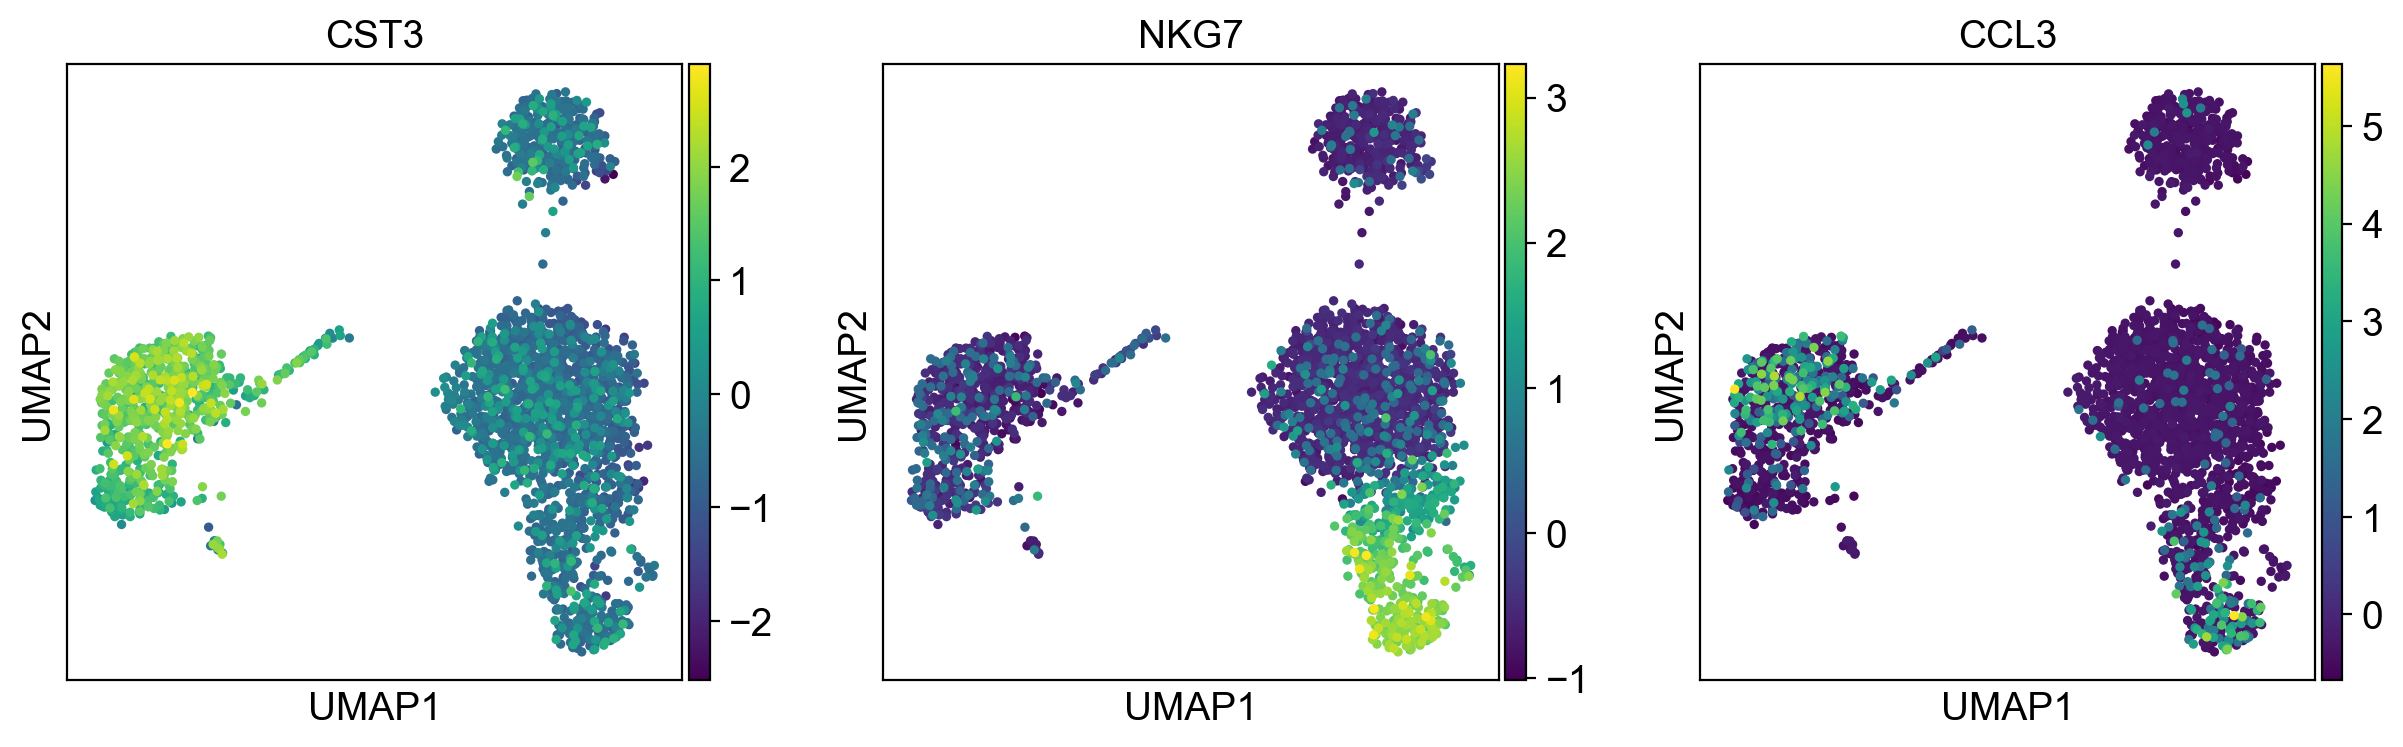

In [32]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'CCL3'], use_raw=False)

### What happens if the graph has disconnected clusters?

In case disconnected clusters are solved, the following recipe may be a remedy

```
## sc.tl.paga: Mapping out the coarse-grained connectivity structures of complex manifolds 
sc.tl.paga(adata)
sc.pg.paga(adata, plot=False) ## remove `plot=False` if you wish to see the coarse-grained graph
sc.tl.umap(adata, init_pos='gata')
```

## Clustering the neighborhood graph

The authors of `scanpy` recommend using the Leiden graph-clustering method, which was developed for community detection based on optimizing modularity, by [Traag *et al.* (2018)](https://arxiv.org/abs/1810.08473). Compared with the Louvain algorithm, the Leiden algorithm yields communities that are garanteed to be connected. When applied iteratively, the Leiden algorithm converges to a partition in which all subsets of all communicities are locally optimally assigned. Last but not least, it runs faster.

In [33]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


We plot the clusters using `sc.pl.umap`. Note that the `color` parameter does not only accept individual genes, but also the clustering method (`leiden` in this case).

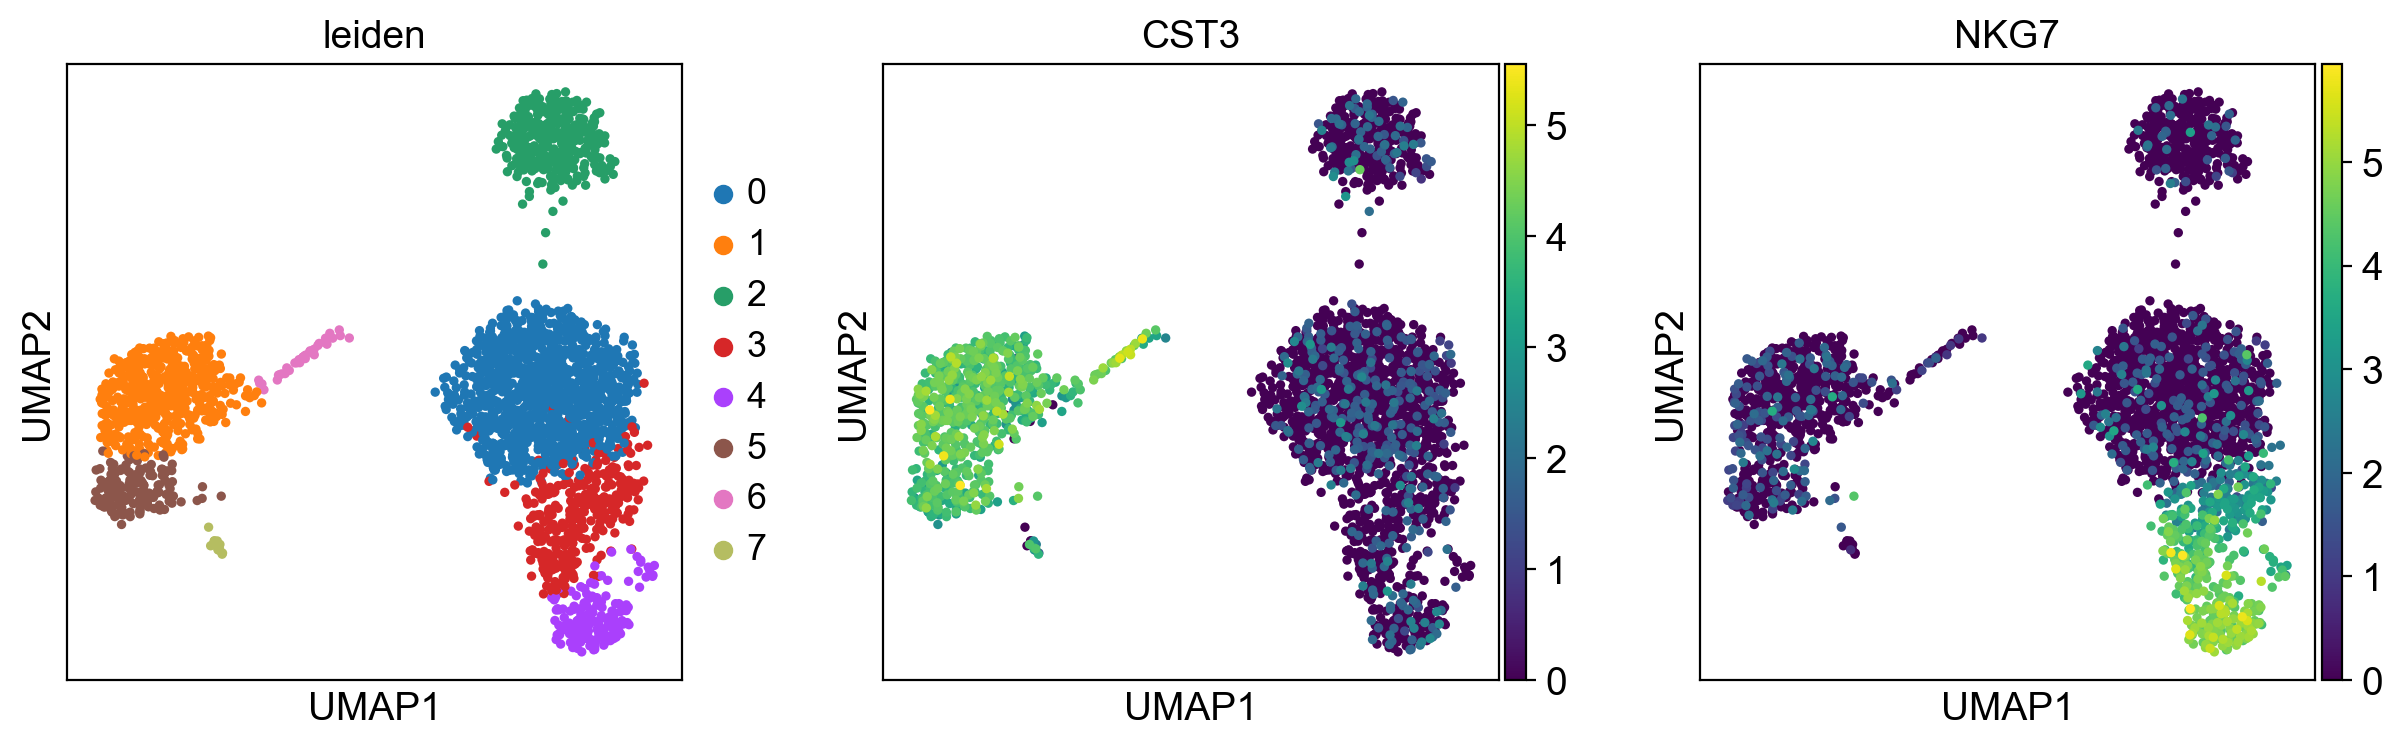

In [34]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

We save the result again.

In [35]:
adata.write(results_file)

## Identifying marker genes

We identify differentially expressed genes between clusters. COmmonly used methods include t-test and Wilcoxon rank-sum (Mann-Whitney-U) test. Other methods include [MAST](https://github.com/RGLab/MAST), limma, DESeq2, and [diffxpy](https://github.com/theislab/diffxpy) by the Theis lab.

Note that by default, the raw data is used if present.

### The Wilcoxon's test

For simplicity, we start with the Mann-Whitney-U test. The null hypothesis is that the rank of a gene in a cluster is the same as its rank in all cells. The alternative hypothesis is that the rank of a gene in a cluster is much higher than its rank in all cells (one-sided). The function `sc.tl.rank_genes_groups` performs the test, and `sc.pl.rank_genes_groups` plots the top genes.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


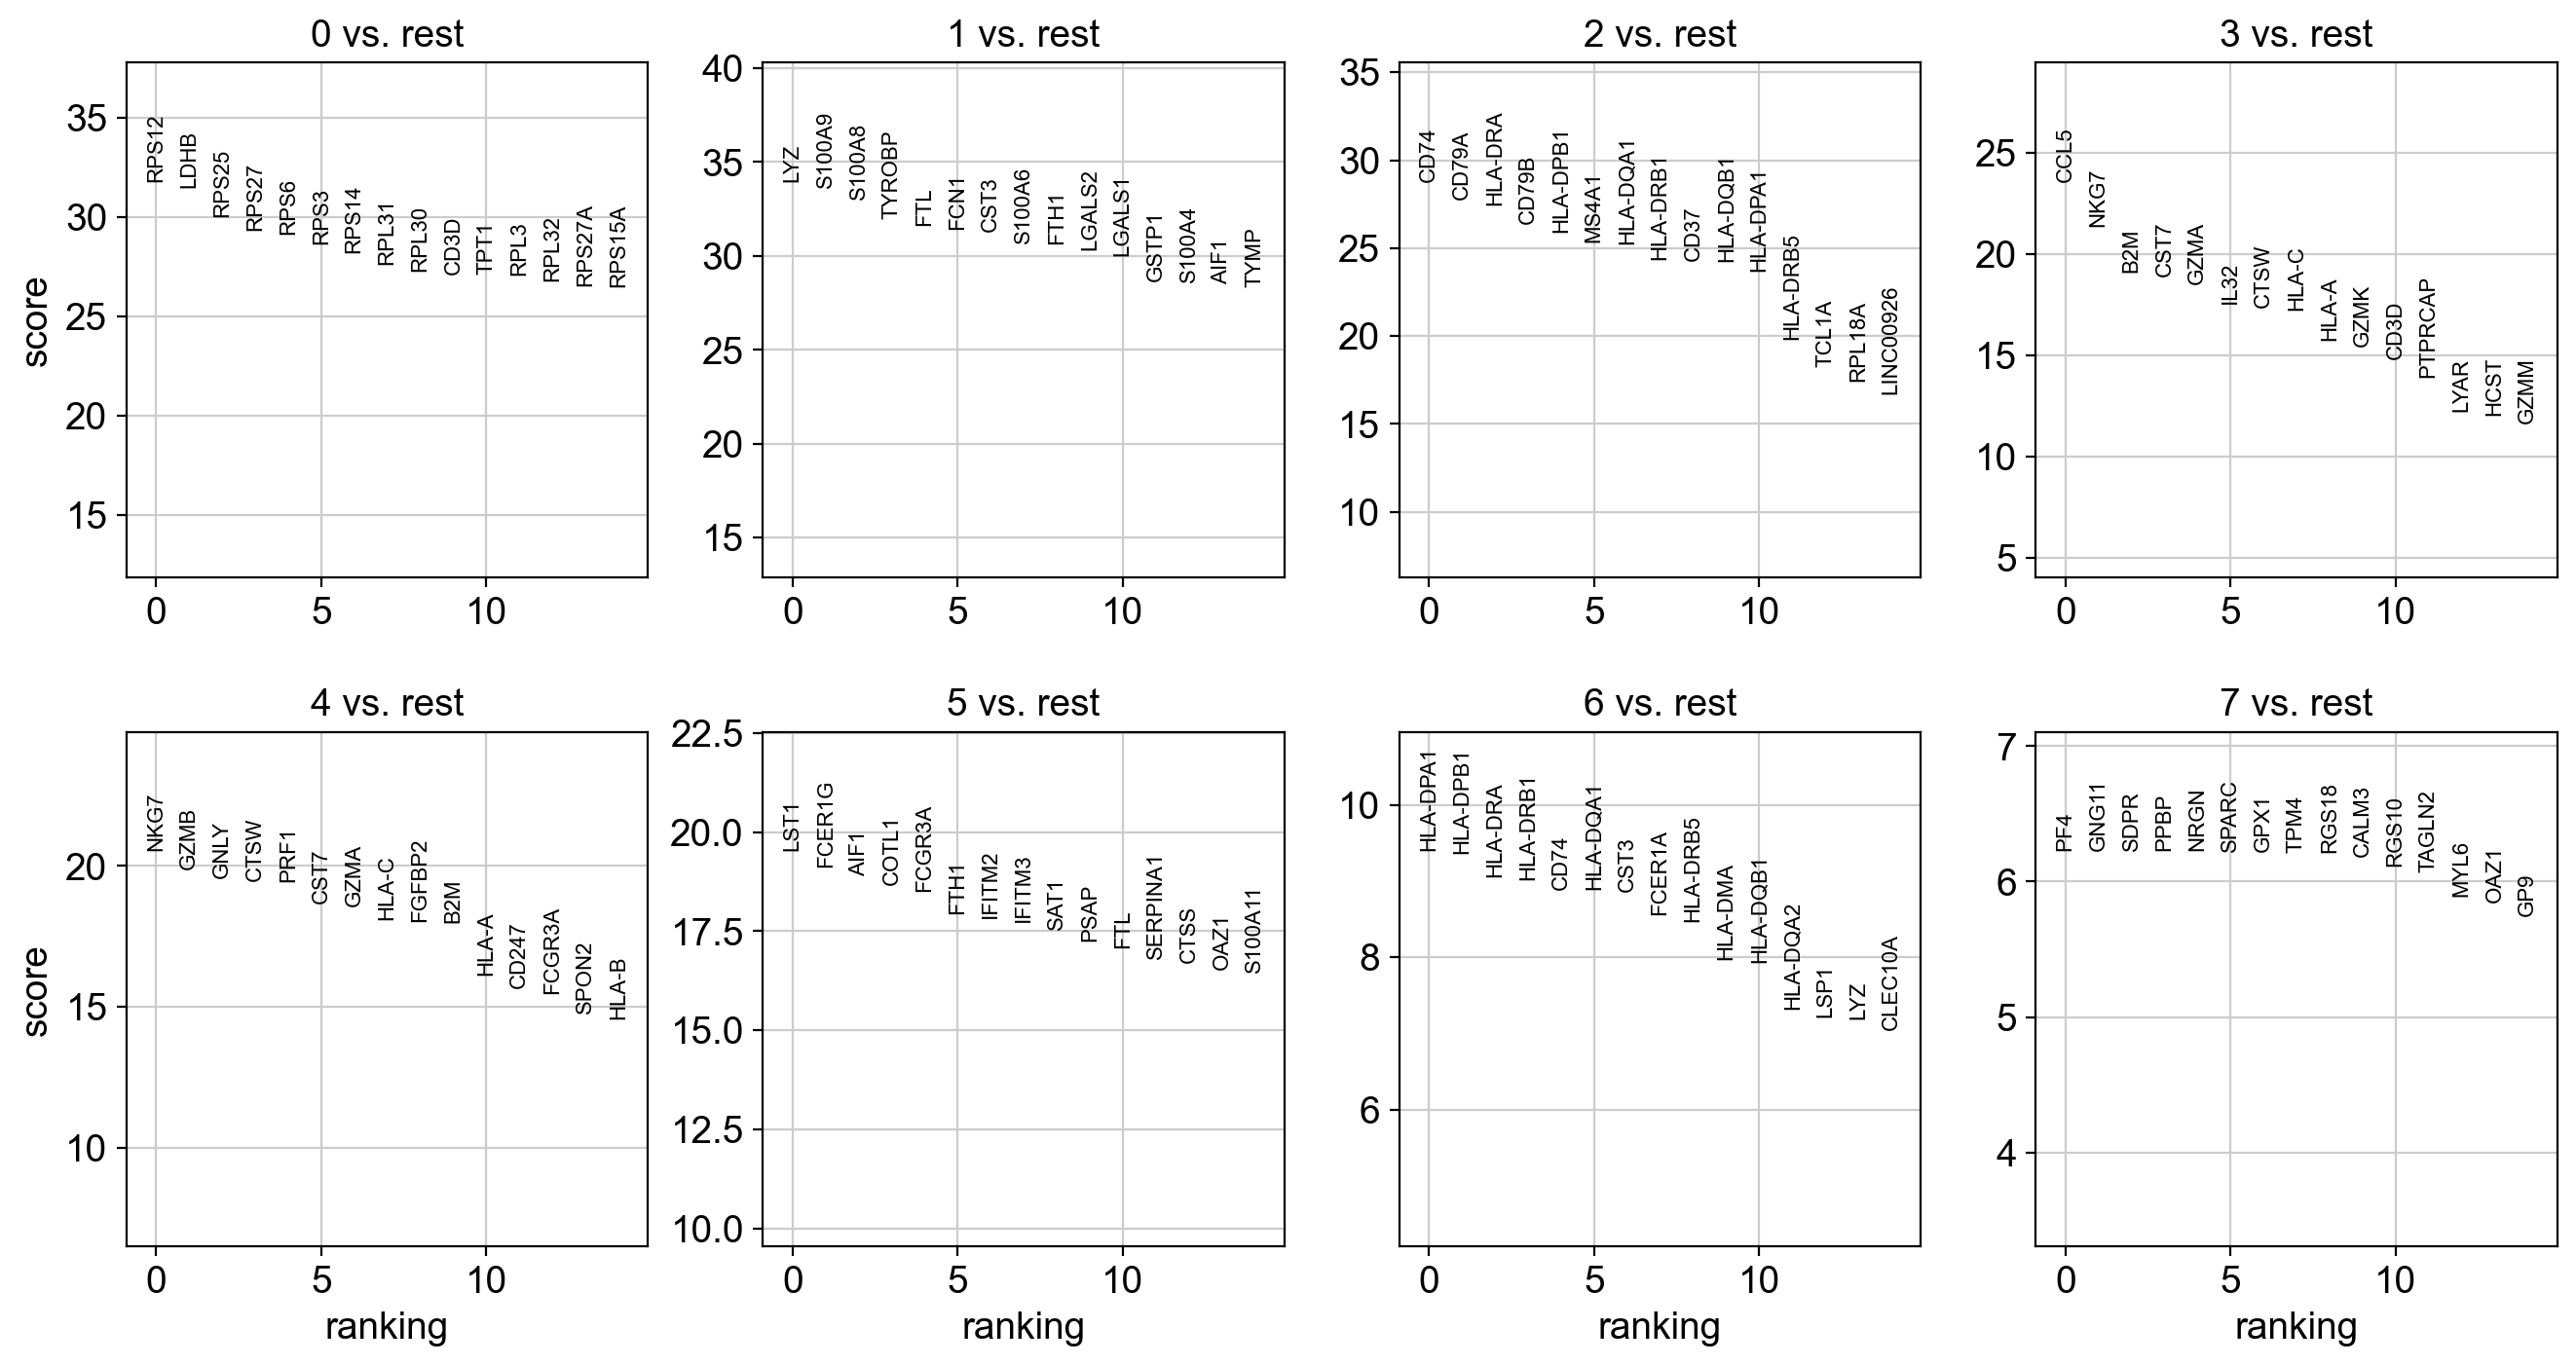

In [36]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

In [37]:
adata.write(results_file)

### The Student's t-test

An alternative to the non-parametric Wilcoxon test is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


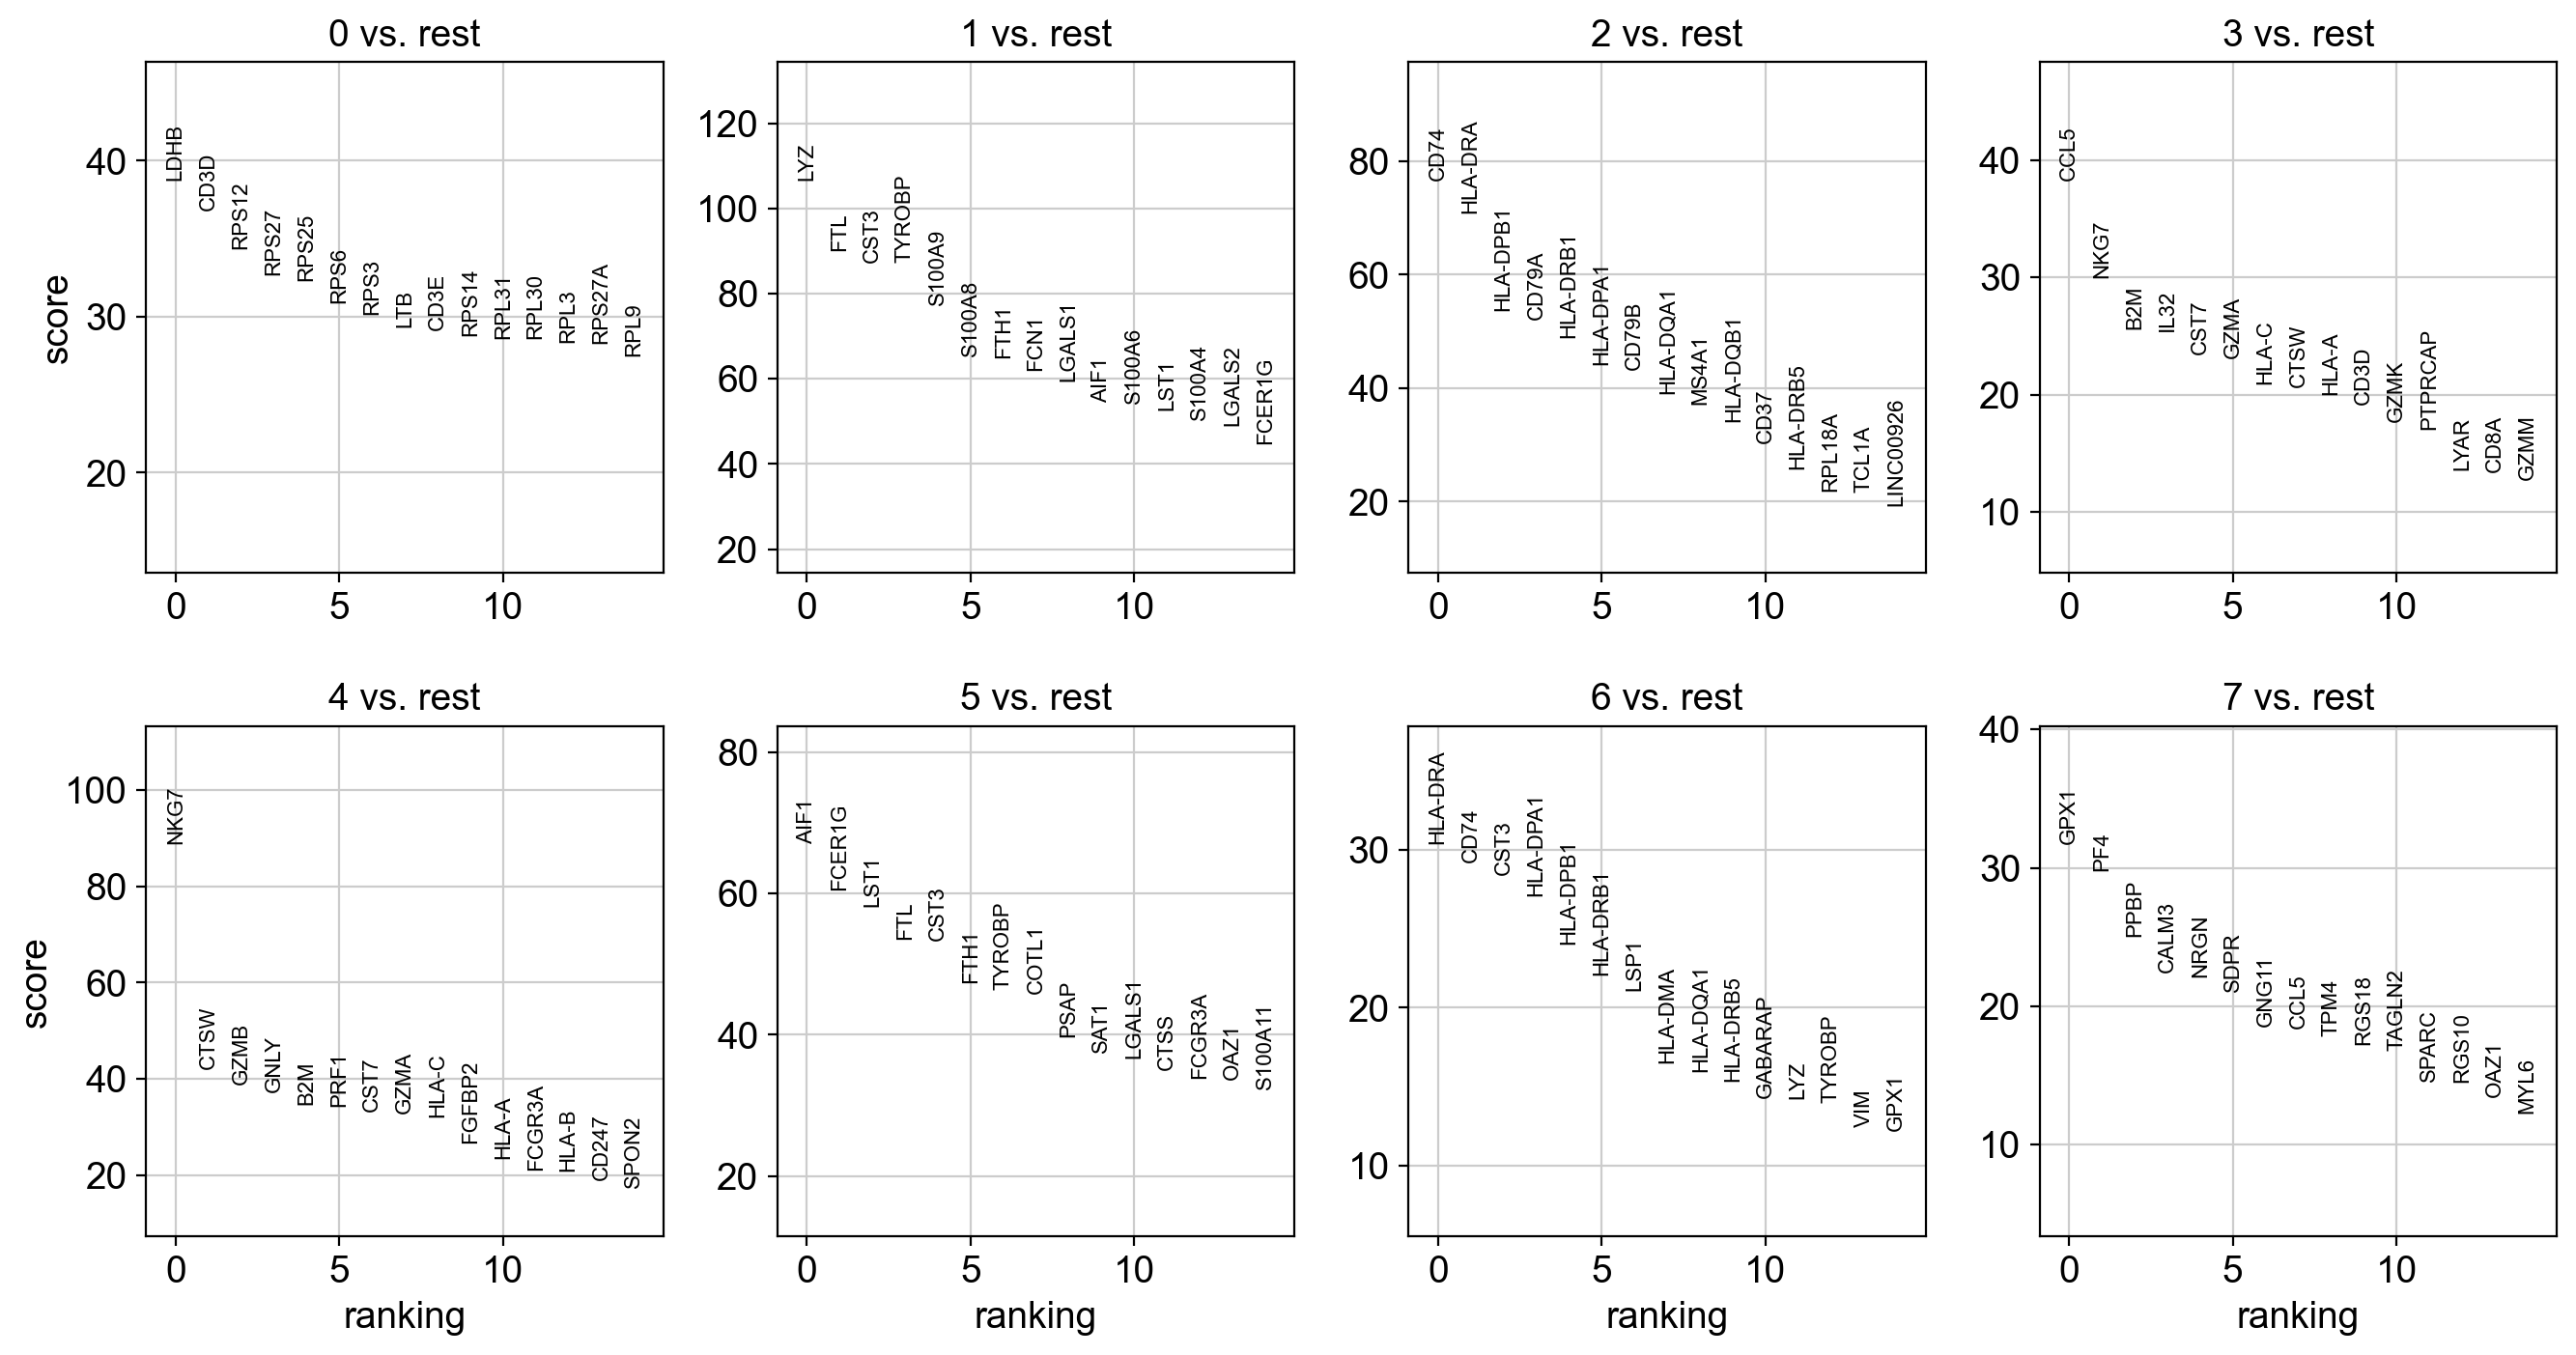

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:12)


/home/david/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


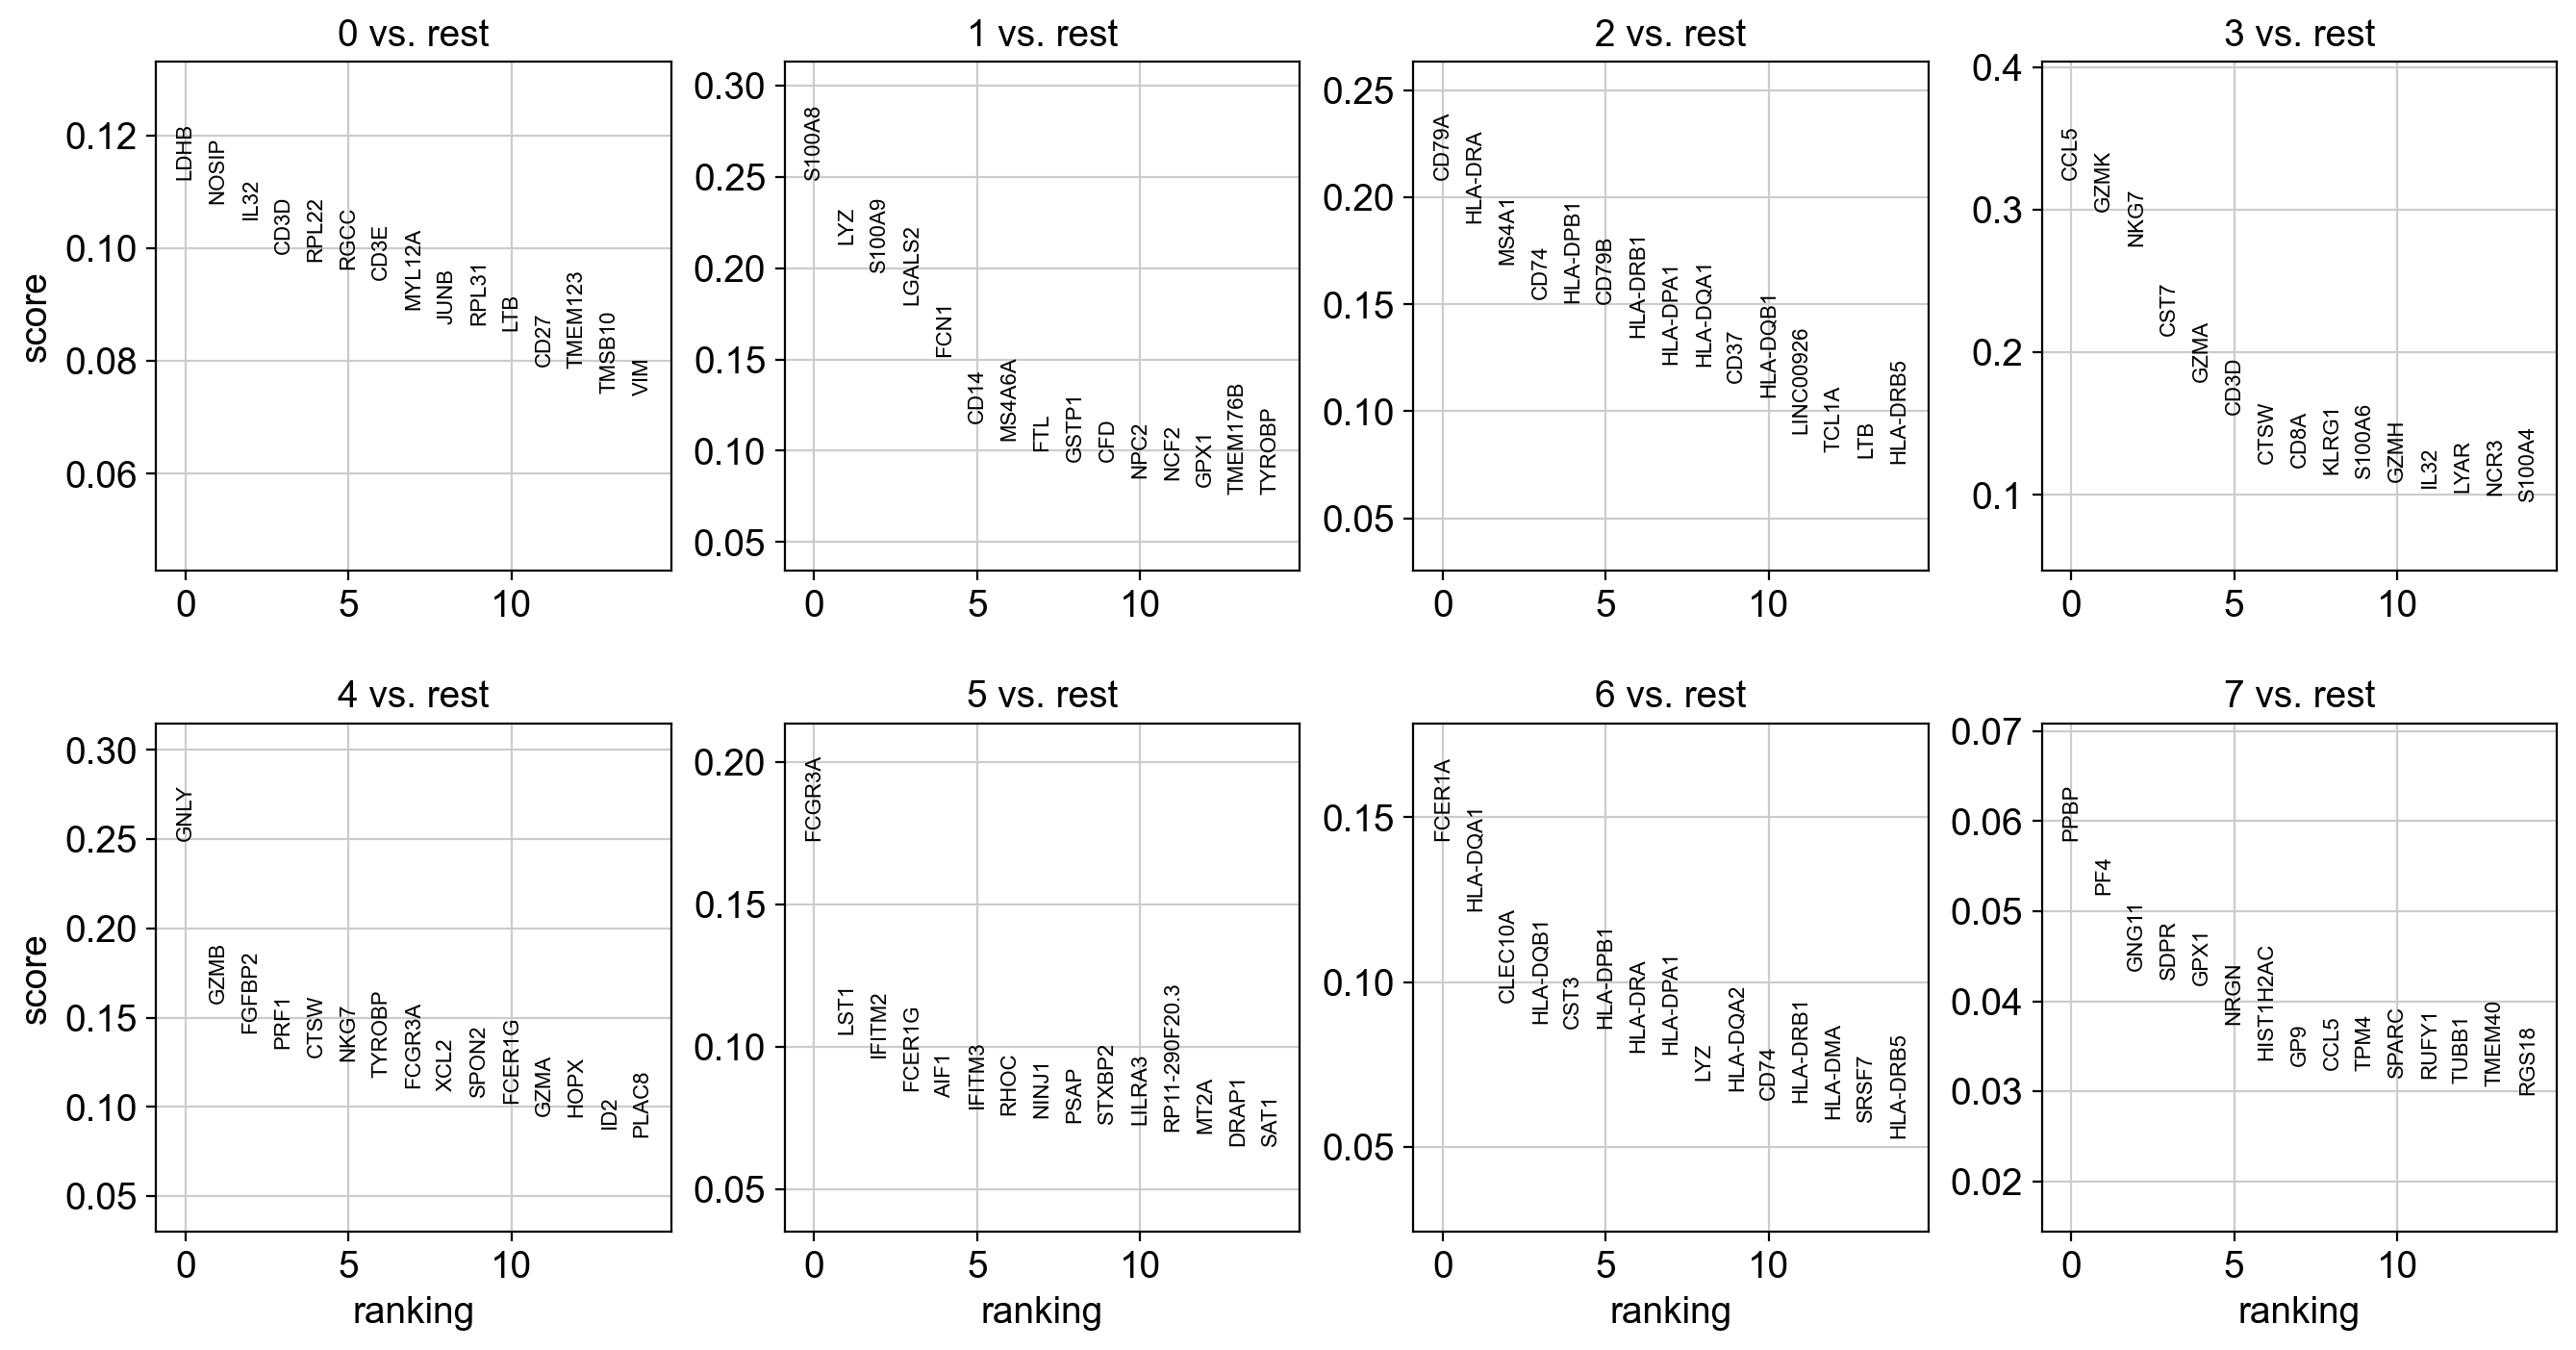

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method="logreg")
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

### Listing signatures using the results of the Wilcoxon's test

We use the results of the Wilcoxon's test for down-stream analysis.

In [40]:
adata = sc.read(results_file)

We shoud the top 10 ranked genes per cluster in a data frame.

In [41]:
top_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
top_genes.head(5)

0       1         2     3     4       5         6      7
0  RPS12     LYZ      CD74  CCL5  NKG7    LST1  HLA-DPA1    PF4
1   LDHB  S100A9     CD79A  NKG7  GZMB  FCER1G  HLA-DPB1  GNG11
2  RPS25  S100A8   HLA-DRA   B2M  GNLY    AIF1   HLA-DRA   SDPR
3  RPS27  TYROBP     CD79B  CST7  CTSW   COTL1  HLA-DRB1   PPBP
4   RPS6     FTL  HLA-DPB1  GZMA  PRF1  FCGR3A      CD74   NRGN

In [42]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

We make a data frame that contains both scores and groups.

In [43]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
top_df = pd.DataFrame(
  {group + '_' + key[:1]: result[key][group]
  for group in groups for key in ['names', 'pvals']})
top_df.head(5)

0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  1.038484e-221     LYZ  1.007060e-252      CD74  3.043536e-182  CCL5   
1   LDHB  4.017772e-217  S100A9  3.664292e-248     CD79A  6.860832e-170  NKG7   
2  RPS25  5.769616e-198  S100A8  9.457377e-239   HLA-DRA  8.389292e-166   B2M   
3  RPS27  3.157468e-189  TYROBP  2.209430e-224     CD79B  1.171444e-153  CST7   
4   RPS6  1.597541e-186     FTL  3.910903e-219  HLA-DPB1  6.167786e-148  GZMA   

             3_p   4_n           4_p     5_n           5_p       6_n  \
0  6.344889e-123  NKG7  1.006113e-93    LST1  5.650219e-85  HLA-DPA1   
1  2.356419e-101  GZMB  5.598162e-88  FCER1G  1.697236e-81  HLA-DPB1   
2   3.831296e-81  GNLY  2.214727e-85    AIF1  1.377723e-79   HLA-DRA   
3   1.094037e-79  CTSW  2.404718e-84   COTL1  9.684016e-78  HLA-DRB1   
4   1.996515e-76  PRF1  5.451777e-84  FCGR3A  2.516161e-76      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21  GNG11  4.733899e-10  
2  1.306768e-19   SDPR  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

### One-versus-one instead of one-versus-all

The previous approaches identify differentially expressed genes comparing one cluster against all clusters. Alternately, this can be done by comparing one cluster versus another. For instance, the example below compares group 0 versus group 1.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


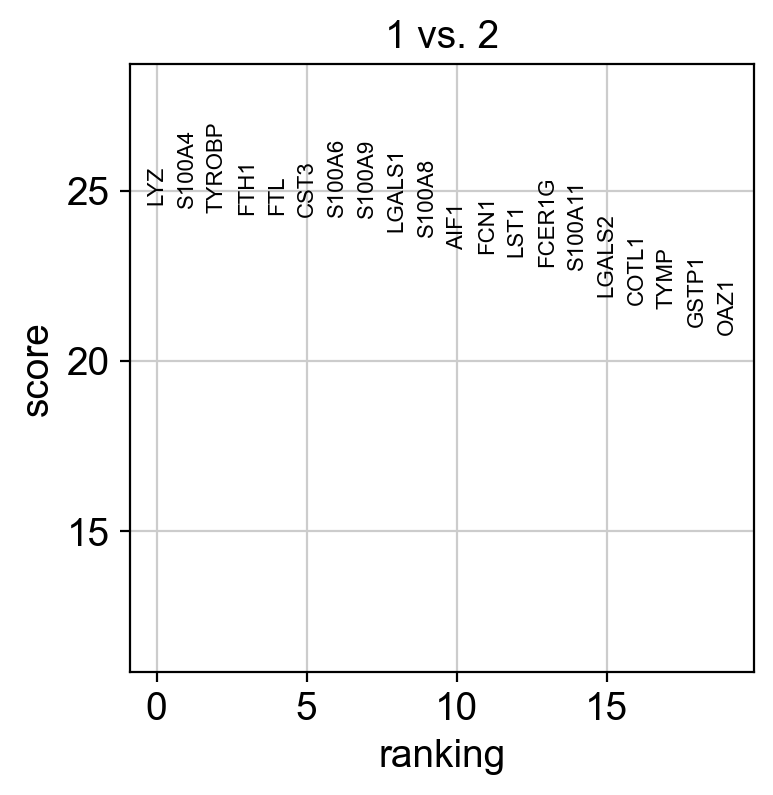

In [44]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['1'], reference='2', method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=['1'], ngenes=20)

#### Detailed view of signatures of a certain group

We can view the difference of distributions of signatures of a certain group in this group and in all cells with `sc.pl.rank_genes_groups_violin`. Note that the groups given must match the groups given in th command calling `sc.tl.the rank_genes_groups`.

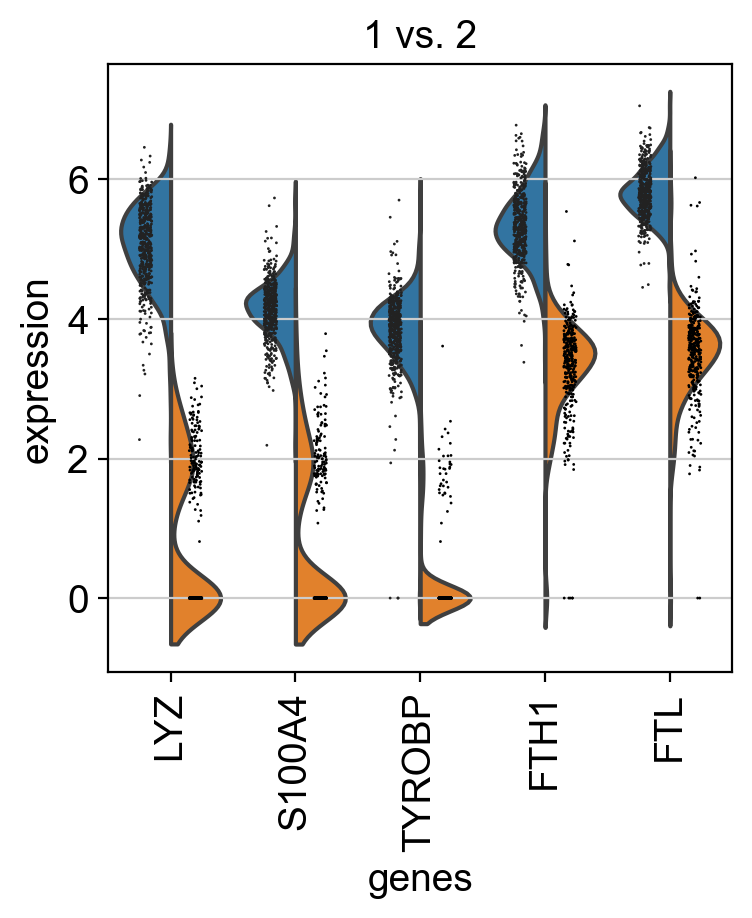

In [45]:
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=5)

Reload the object that computed differential expression by comparing one versus all.

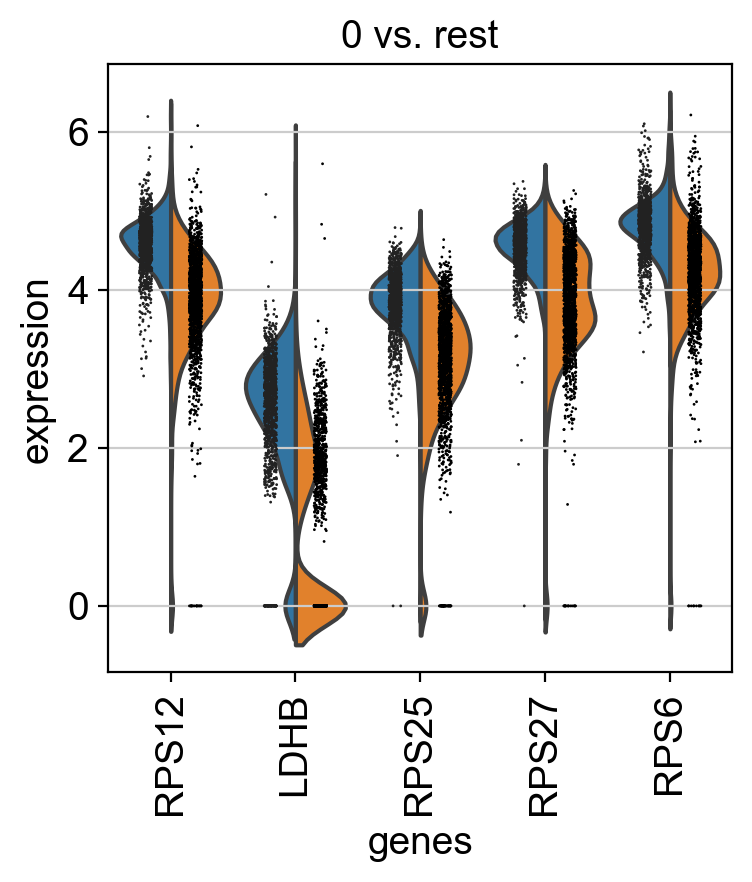

In [46]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=5)

## Visualizing marker genes and cell populations

Besides the visualizations above, scanpy offers many useful functions for visualizing marker genes and cell populations.

### Comparing individual genes across groups

We can use `sc.pl.violin` to compare expression of one or more genes across groups.

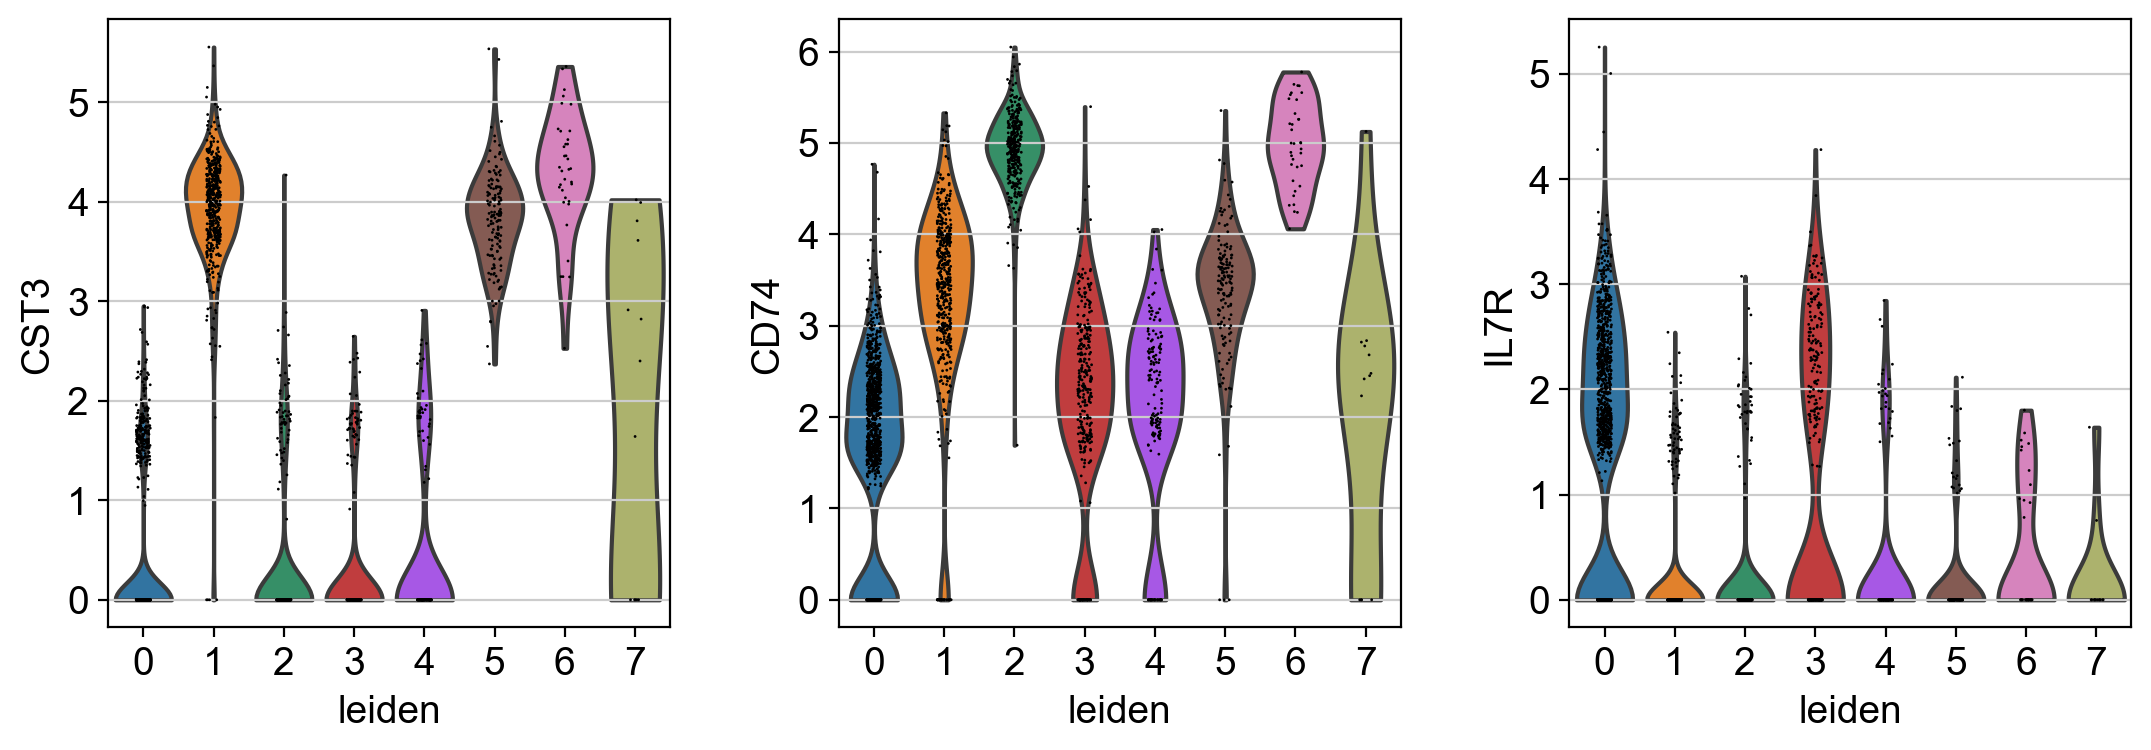

In [47]:
sc.pl.violin(adata, ['CST3', 'CD74', 'IL7R'], groupby='leiden')

### Labelling cell types

We use `AnnData.rename_categories` to assign names to categories

In [48]:
new_cluster_names = [
    'CD4 T', 'CD14 monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

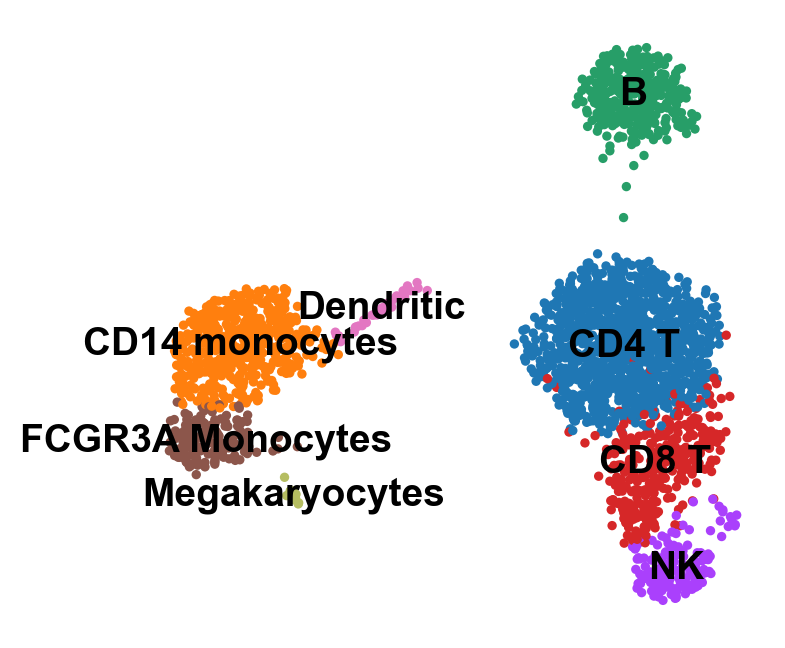

In [49]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='',
           frameon=False, save='.pdf')

### Visualizing marker genes with dotplot

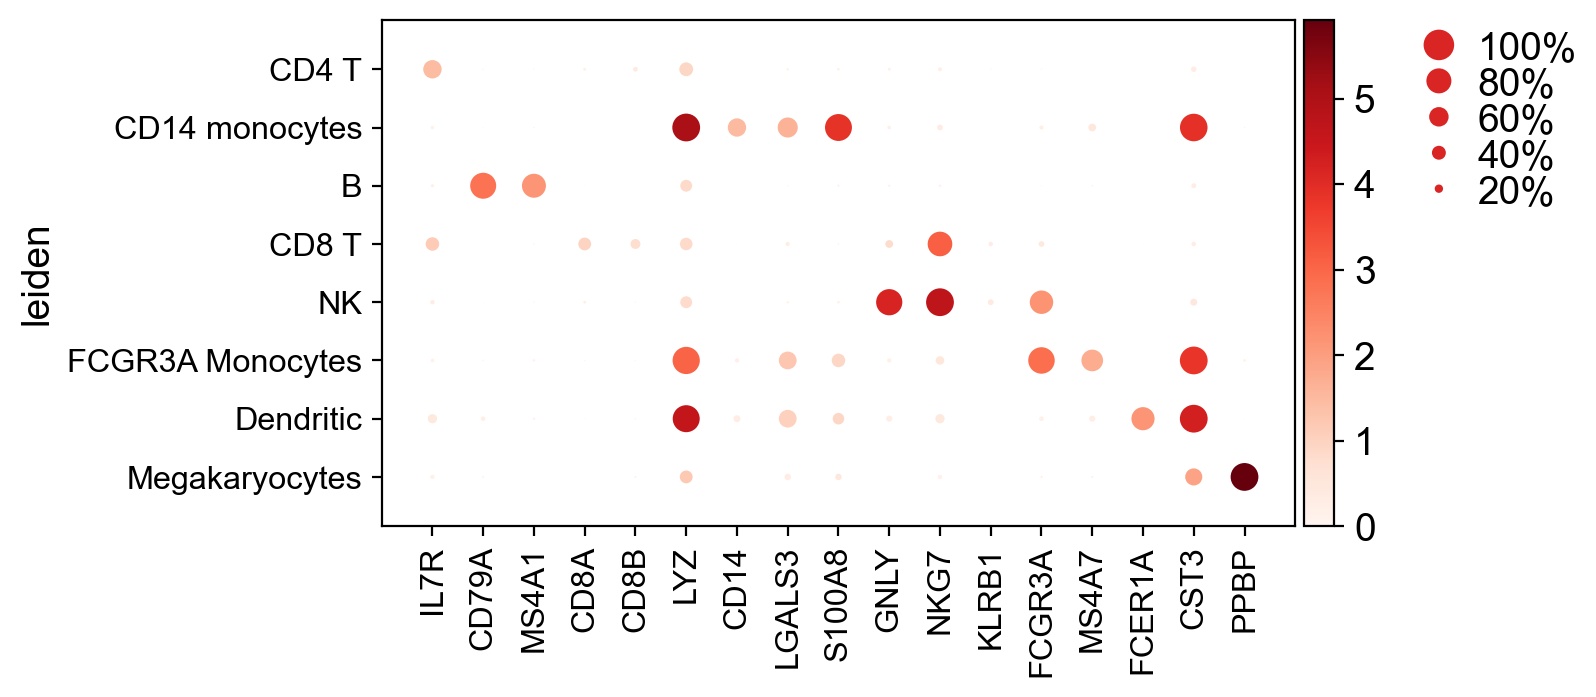

In [50]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='leiden')

### Visualizing marker genes with violin plot

The violin plot also provides a compact visualization of the marker genes.

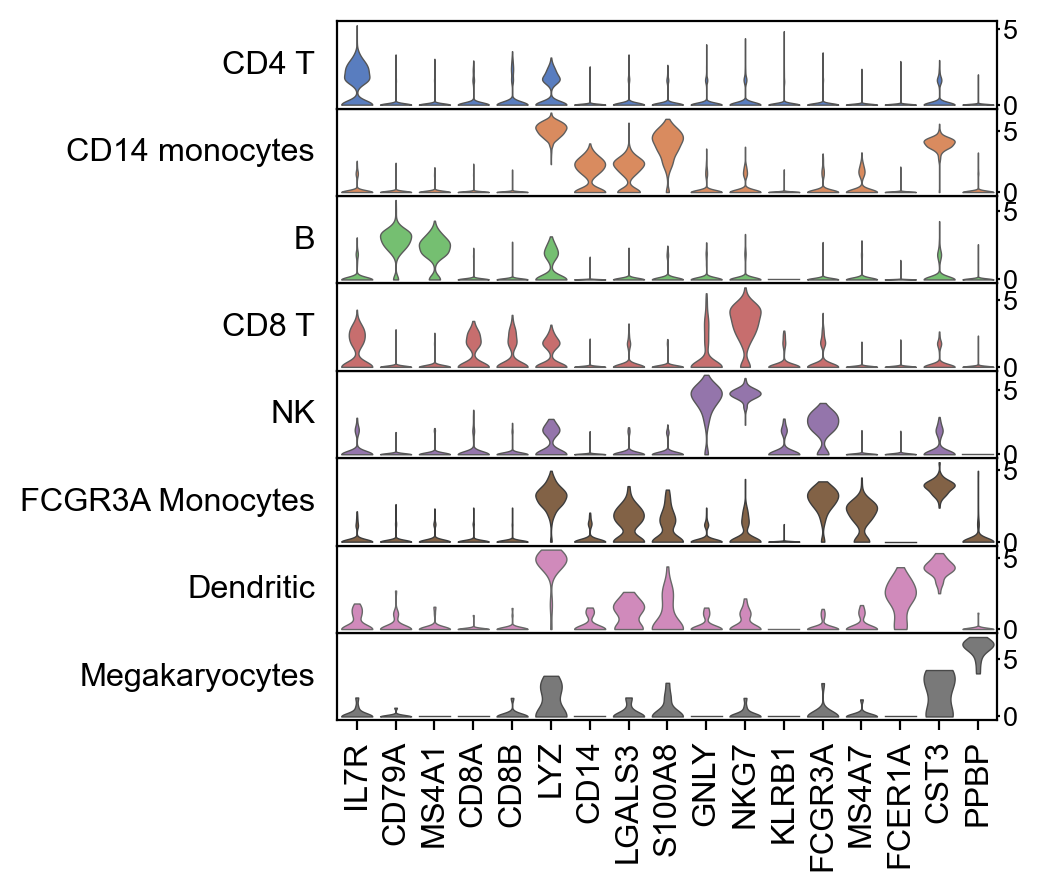

In [51]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

## Export the analysis result

We can examine our AnnData object now. It contains 2638 cells and 1838 genes.

In [52]:
print(adata)

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


### Saving as gzip

One is to use `gzip`, which saves disk space, but both reading and writing is slow.

In [53]:
adata.write(results_file, compression='gzip')

### Saving as h5ad

Another way is to save the result in a H5 file, more specifically, a `.h5ad` result file. See the technical specifications here on GitHub [theislab/scanpy_usage](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). It provides much flexibility in storing the results, better speed, and the authors claim that they will remain backwards-compatible.

In [58]:
adata.write('./write/pbmc3k_withoutX.h5ad', compression='gzip')

### Saving as csv

There are three options

1. Export single fields of the annotation of observations
```
adata.obs[['n_counts', 'louvain_groups']].to_csv(
    './write/pbmc3k_corrected_louvain_groups.csv')
```
1. Export single columns of the multidimensional annotation
```
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
    './write/pbmc3k_corrected_X_pca
```
1. Export everything but the data, using `.write_csvs`
```
adata.write_csvs(results_file[:-5], )
```

## Summary

With the tutorial, we have a first impression of the key tools implemented by scanpy to handle single-cell RNA sequencing data.

In particular, we learned how to pre-process the data by producing QC metrics and filtering genes and cells iteratively. We used both a dimension reduction technique (PCA) and a toplogical data analysis tool (UMAP) to generate the neighbourhood graph of cells and embed the manifold of single-cell expression data in a 2D presentation. We learned how to use different methods including the t-test, the Wilcoxon test, and logistic regression to identify marker genes. We also tried different ways to visualize these marker genes using dotplot and violin plot, and one way to annotate cell populations. Finally, we learned three ways how to expore the analysis results.

If you want to learn more about applications of scanpy, please check out its tutorials at [scanpy-tutorials.readthedocs.io](https://scanpy-tutorials.readthedocs.io/en/latest/). You will find among others tutorials on (a) trajectory inference, (b) more techniques to visualize marker genes, (c) how to integrate different datasets, (d) analysis of spatial transcriptomics data, (e) integrating spatial data with scRNA-seq data, and (f) analysis of CITE-seq data.

If you are intersted in learning how the besca complements the scanpy package for single-cell RNA sequencing analysis, please check out my follow-up tutorial of besca.